# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [2]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [18]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

[0.05339572 0.11328112 0.16293002 0.08250906 0.10325144 0.05562836
 0.04808378 0.13231388 0.10663806 0.14196856]
[0.04840416 0.0797839  0.08611935 0.08319628 0.03319005 0.1141599
 0.19335931 0.05341875 0.18362714 0.12474116]
[0.19127274 0.08727548 0.05987879 0.1344308  0.10541442 0.10654608
 0.0272677  0.08929977 0.14642097 0.05219325]
[0.04315113 0.14763569 0.14183426 0.01976169 0.08038893 0.11541452
 0.17841003 0.06093872 0.10751664 0.1049484 ]
[0.08371623 0.08716419 0.11099631 0.13987386 0.1345147  0.08093202
 0.06039378 0.13115238 0.08943165 0.08182488]
[0.1083818  0.07504497 0.0797461  0.1581964  0.06438553 0.1048611
 0.11289331 0.05207144 0.14866018 0.09575917]
[0.0714437  0.11601659 0.07497255 0.06896743 0.12233234 0.04752395
 0.2119963  0.09731526 0.07622078 0.1132111 ]
[0.07511697 0.14485506 0.13763302 0.05651104 0.08565458 0.08505115
 0.09786713 0.123177   0.07883566 0.1152984 ]
[0.07337169 0.07766242 0.09753974 0.08379647 0.14486923 0.09272715
 0.10509142 0.11969167 0.101157

[0.07536253 0.10820113 0.10915243 0.08788863 0.1509037  0.05458202
 0.12720173 0.11195156 0.06897571 0.10578055]
[0.11117902 0.10959275 0.10543401 0.12267333 0.07537325 0.08934265
 0.10949029 0.08621312 0.09692462 0.09377696]
[0.10084539 0.08265342 0.13224347 0.10497021 0.11597906 0.05479781
 0.09367741 0.06770178 0.10744738 0.13968407]
[0.05889467 0.16695471 0.09694179 0.08885542 0.12199395 0.04657341
 0.14069595 0.0682786  0.08217255 0.12863896]
[0.04230198 0.1380339  0.09235551 0.04014394 0.10647181 0.03872337
 0.26052817 0.12964889 0.04252315 0.10926928]
[0.07685225 0.12020734 0.06988386 0.05910983 0.11599634 0.14043776
 0.09522381 0.11095589 0.06886089 0.14247203]
[0.06812466 0.08234758 0.10481522 0.06309532 0.09484405 0.06242947
 0.20494365 0.09222981 0.08639174 0.1407785 ]
[0.10804132 0.06759932 0.10973011 0.13316697 0.0961944  0.07316545
 0.11199031 0.10585762 0.14080424 0.05345026]
[0.06328311 0.1050226  0.10079239 0.09375507 0.11809424 0.10529346
 0.03565467 0.16219273 0.1184

## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [30]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.363025 analytic: -0.363025, relative error: 6.506269e-08
numerical: -0.934128 analytic: -0.934128, relative error: 7.805068e-08
numerical: -0.280817 analytic: -0.280817, relative error: 1.646209e-08
numerical: -2.386933 analytic: -2.386933, relative error: 3.367043e-08
numerical: -5.052991 analytic: -5.052991, relative error: 8.894338e-09
numerical: 1.264452 analytic: 1.264452, relative error: 3.296299e-08
numerical: -0.397437 analytic: -0.397437, relative error: 1.065945e-07
numerical: -1.288507 analytic: -1.288507, relative error: 4.035502e-08
numerical: 0.519595 analytic: 0.519595, relative error: 9.496176e-08
numerical: 0.890627 analytic: 0.890627, relative error: 2.076519e-08
numerical: 3.811778 analytic: 3.811778, relative error: 1.601460e-08
numerical: -0.548137 analytic: -0.548137, relative error: 3.778415e-08
numerical: 0.669059 analytic: 0.669059, relative error: 4.362958e-09
numerical: 1.216093 analytic: 1.216093, relative error: 1.956247e-08
numerical: 2.07726

In [34]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.400127e+00 computed in 0.080824s
vectorized loss: 2.400127e+00 computed in 0.004714s
Loss difference: 0.000000
Gradient difference: 0.000000


In [79]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 3e-7, 1e-6]
regularization_strengths = [1e4, 3e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

for lr in learning_rates: # Go over the learning rates
    for reg in regularization_strengths: # Go over the regularization strengths
        model = Softmax()
        model.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=2000, verbose=True)
        
        train = np.mean(y_train == model.predict(X_train))
        val = np.mean(y_val == model.predict(X_val))
        
        # Store our results in a dict.
        results[(lr, reg)] = (train,val)

        if best_val < val:
            best_val = val 
            best_softmax = model 
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 310.852417
iteration 100 / 2000: loss 207.710118
iteration 200 / 2000: loss 139.532693
iteration 300 / 2000: loss 93.765479
iteration 400 / 2000: loss 63.359549
iteration 500 / 2000: loss 43.026253
iteration 600 / 2000: loss 29.478722
iteration 700 / 2000: loss 20.385353
iteration 800 / 2000: loss 14.267114
iteration 900 / 2000: loss 10.237898
iteration 1000 / 2000: loss 7.503989
iteration 1100 / 2000: loss 5.724803
iteration 1200 / 2000: loss 4.406647
iteration 1300 / 2000: loss 3.595725
iteration 1400 / 2000: loss 3.107811
iteration 1500 / 2000: loss 2.757290
iteration 1600 / 2000: loss 2.459250
iteration 1700 / 2000: loss 2.365901
iteration 1800 / 2000: loss 2.182573
iteration 1900 / 2000: loss 2.135006
iteration 0 / 2000: loss 9147.093355
iteration 100 / 2000: loss 2.288582
iteration 200 / 2000: loss 2.235961
iteration 300 / 2000: loss 2.252360
iteration 400 / 2000: loss 2.241518
iteration 500 / 2000: loss 2.250756
iteration 600 / 2000: loss 2.246941
iterat

In [80]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.356000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

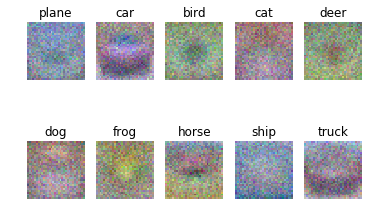

In [81]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])